In [ ]:
import os
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

DATA_DIR = Path("/kaggle/input/imagesoasis/Data")
KEEP_CLASSES = ["Non Demented", "Very mild Dementia", "Mild Dementia"]
DOWN_TARGET = 10000   




In [ ]:

items = []

for cls in KEEP_CLASSES + ["Moderate Dementia"]:
    folder = DATA_DIR / cls
    files = sorted([f for ext in ("*.jpg", "*.png", "*.jpeg") for f in folder.glob(ext)])

    for f in files:
        items.append((str(f), cls))

df = pd.DataFrame(items, columns=["path", "label_name"])
print("Loaded images:", len(df))




Loaded images: 86437


In [ ]:

df = df[df["label_name"].isin(KEEP_CLASSES)].reset_index(drop=True)
print("\nRemaining (3 classes only):")
print(df["label_name"].value_counts())





Remaining (3 classes only):
label_name
Non Demented          67222
Very mild Dementia    13725
Mild Dementia          5002
Name: count, dtype: int64


In [ ]:


balanced = []

for cls in KEEP_CLASSES:
    cls_df = df[df["label_name"] == cls]


    if cls in ["Non Demented", "Very mild Dementia"] and len(cls_df) > DOWN_TARGET:
        cls_df = cls_df.sample(DOWN_TARGET, random_state=42)

    balanced.append(cls_df)

balanced_df = pd.concat(balanced).reset_index(drop=True)

print("\nAfter balancing:")
print(balanced_df["label_name"].value_counts())




After balancing:
label_name
Non Demented          10000
Very mild Dementia    10000
Mild Dementia          5002
Name: count, dtype: int64


In [ ]:


train_list = []
val_list = []
test_list = []

for cls in KEEP_CLASSES:
    cls_df = balanced_df[balanced_df["label_name"] == cls]

   
    train_tmp, temp = train_test_split(
        cls_df, test_size=0.20, shuffle=True, random_state=42
    )


    val_tmp, test_tmp = train_test_split(
        temp, test_size=0.50, shuffle=True, random_state=42
    )

    train_list.append(train_tmp)
    val_list.append(val_tmp)
    test_list.append(test_tmp)

train_df3 = pd.concat(train_list).reset_index(drop=True)
val_df3   = pd.concat(val_list).reset_index(drop=True)
test_df3  = pd.concat(test_list).reset_index(drop=True)



In [ ]:


train_df3.to_csv("train_df3.csv", index=False)
val_df3.to_csv("val_df3.csv", index=False)
test_df3.to_csv("test_df3.csv", index=False)

print("\nSaved:")
print("train_df3.csv:", len(train_df3))
print("val_df3.csv:", len(val_df3))
print("test_df3.csv:", len(test_df3))




Saved:
train_df3.csv: 20001
val_df3.csv: 2500
test_df3.csv: 2501


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 40
LR = 1e-4
AUTOTUNE = tf.data.AUTOTUNE
KEEP_CLASSES = ["Non Demented", "Very mild Dementia", "Mild Dementia"]



2025-11-26 17:22:27.615863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764177747.853523      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764177747.915548      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:

train_df3 = pd.read_csv("train_df3.csv")
val_df3   = pd.read_csv("val_df3.csv")
test_df3  = pd.read_csv("test_df3.csv")

label_to_idx = {name: i for i, name in enumerate(KEEP_CLASSES)}
train_df3["label_idx2"] = train_df3["label_name"].map(label_to_idx)
val_df3["label_idx2"]   = val_df3["label_name"].map(label_to_idx)
test_df3["label_idx2"]  = test_df3["label_name"].map(label_to_idx)



In [ ]:

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)
    img = resnet_preprocess(img)
    return img, label

def augment(image, label):
    image = tf.image.random_brightness(image, 0.02)
    image = tf.image.random_contrast(image, 0.98, 1.02)
    noise = tf.random.normal(tf.shape(image), stddev=2.0)
    image = tf.clip_by_value(image + noise, -128.0, 128.0)
    return image, label

def df_to_ds(df, shuffle=False, aug=False):
    ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["label_idx2"].values))

    if shuffle:
        ds = ds.shuffle(10000)

    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    if aug:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)

    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = df_to_ds(train_df3, shuffle=True, aug=True)
val_ds   = df_to_ds(val_df3)
test_ds  = df_to_ds(test_df3)




I0000 00:00:1764177763.843675      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:

y = train_df3["label_idx2"].values
weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weights = {i: float(w) for i, w in enumerate(weights)}


In [ ]:

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

base = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)
base.trainable = False  

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:

checkpoint = callbacks.ModelCheckpoint(
    "best_resnet.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

reduce = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)




In [ ]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[checkpoint, early, reduce]
)



Epoch 1/40


I0000 00:00:1764177776.581198     114 service.cc:148] XLA service 0x7f3aec04c390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764177776.581936     114 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764177778.191001     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


   5/1251 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.7354 - loss: 0.6342 

I0000 00:00:1764177781.772494     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6947 - loss: 0.5983
Epoch 1: val_loss improved from inf to 0.65810, saving model to best_resnet.keras
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 94s 66ms/step - accuracy: 0.6947 - loss: 0.5984 - val_accuracy: 0.7204 - val_loss: 0.6581 - learning_rate: 1.0000e-04
Epoch 2/40
1250/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7742 - loss: 0.4469
Epoch 2: val_loss improved from 0.65810 to 0.54340, saving model to best_resnet.keras
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - accuracy: 0.7741 - loss: 0.4471 - val_accuracy: 0.7812 - val_loss: 0.5434 - learning_rate: 1.0000e-04
Epoch 3/40
1250/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8120 - loss: 0.3925
Epoch 3: val_loss improved from 0.54340 to 0.48259, saving model to best_resnet.keras
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - accuracy: 0.8120 - loss: 0.3926 - val_accuracy: 0.8108 - val_loss: 0.4826 - learning_rate: 1.0000e-04
Epoch 4/40
1250/1251 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:

loss, acc = model.evaluate(test_ds)
print("Test Accuracy:", acc)
print("Test Loss:", loss)

model.save("final_resnet_model.keras")


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9269 - loss: 0.1758
Test Accuracy: 0.9100359678268433
Test Loss: 0.24271394312381744


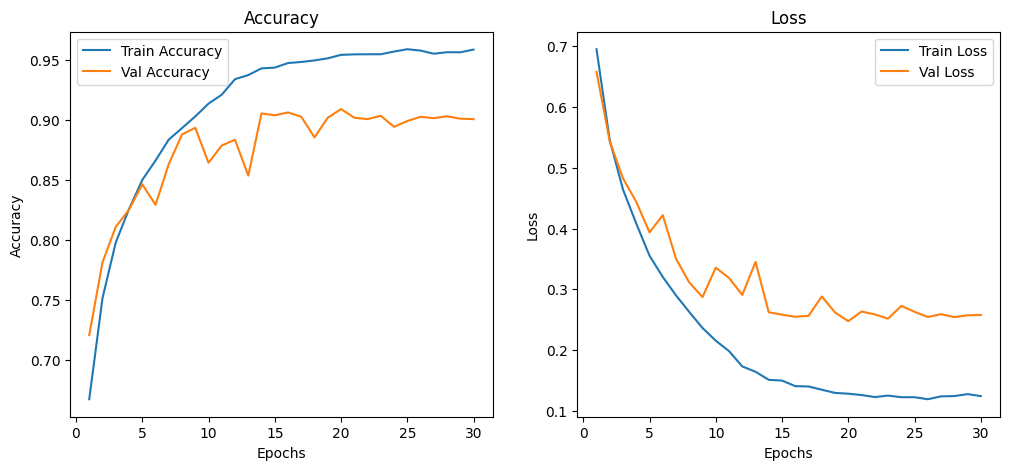

In [ ]:

import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━

<Figure size 600x600 with 0 Axes>

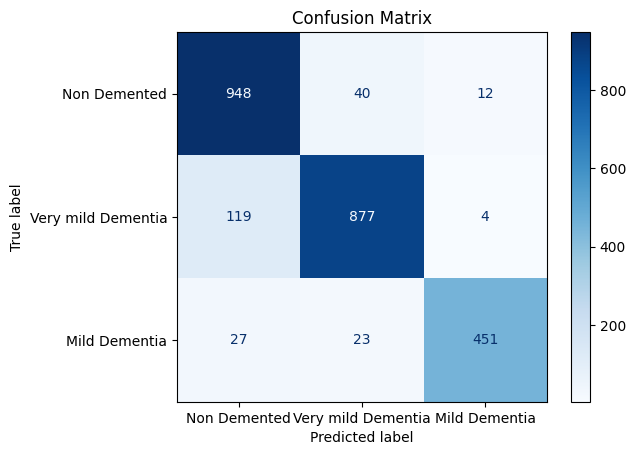

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=KEEP_CLASSES
)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()




In [ ]:

from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for x, y in test_ds:
    preds = model.predict(x, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(y.numpy())

print(classification_report(
    y_true,
    y_pred,
    target_names=KEEP_CLASSES
))




                    precision    recall  f1-score   support

      Non Demented       0.87      0.95      0.91      1000
Very mild Dementia       0.93      0.88      0.90      1000
     Mild Dementia       0.97      0.90      0.93       501

          accuracy                           0.91      2501
         macro avg       0.92      0.91      0.91      2501
      weighted avg       0.91      0.91      0.91      2501

